In [1]:
#Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Read the Data provided
data = pd.read_csv('train.csv', header=0)
#data = pd.read_csv('train.csv', na_values = 'NAN')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Analysis

In [3]:
print("Shape", data.shape)

Shape (1460, 81)


- The dataset has 1460 Rows and 81 columns

**The Target Column: Sale Price** 

#### Checking for Skewness on Target Column:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


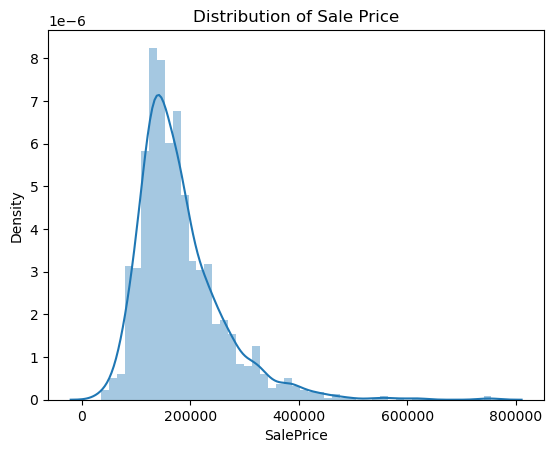

In [4]:
plt.title('Distribution of Sale Price')
sns.distplot(data.SalePrice)
plt.show()

## Data Cleaning

#### Check for Duplicates

In [5]:
def checkDataWithNulls(data):
    dataWithNulls = pd.DataFrame((data.isna() | data.isnull()).sum()[lambda x: x > 0])
    dataWithNulls.rename(columns={0:'Counts'}, inplace=True)
    dataWithNulls['Percentage'] = round(dataWithNulls.Counts*100/data.shape[0], 2)
    print("Count of Columns with missing information:", dataWithNulls.shape[0])
    return None if(dataWithNulls.shape[0] == 0) else dataWithNulls.sort_values(by='Percentage', ascending=False) 

checkDataWithNulls(data)

Count of Columns with missing information: 19


,Counts,Percentage
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


- The columns PoolQC, MiscFeature & Alley have > 90% of data as NA. The Data Dictionary annotates the NA data to be a valid data for some of the columns. Hence, a data transformation can be done here. 

- However, as they are at 90%, it may not provide any insights to the model.



In [6]:
#### Check for Duplicates
unique_data = data.drop_duplicates(inplace=False)
print(unique_data.shape[0] - data.shape[0], "Duplicate records found in the dataset")

0 Duplicate records found in the dataset



- 19 Columns of it have many null values. We need to look forward for cleaning those records... 


In [7]:
data.LotShape = data.LotShape.map({'Reg': 'Regular', 'IR1': 'SlightlyIrregular', 'IR2': 'ModeratelyIrregular', 'IR3': 'Irregular'})
data.LotConfig = data.LotConfig.map({'Inside': 'Inside', 'Corner':'Corner', 'CulDSac': 'CulDSac', 'FR2': 'FrontageOn2Sides', 'FR3': 'FrontageOn3Sides'})

data.LandContour = data.LandContour.map({'Lvl': 'NearFlat', 'Bnk': 'Banked', 'HLS': 'Hillside', 'Low': 'Depression'})
data.LandSlope = data.LandSlope.map({'Gtl': 'Gentle', 'Mod': 'Moderate', 'Sev': 'Severe'})


In [8]:
data.PoolQC = data.PoolQC.map({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'Fa': 'Fair', np.nan: 'NoPool'})
data.MiscFeature = data.MiscFeature.map({'Elev': 'Elevator', 'Gar2': '2ndGarage', 'Othr': 'Other', 'Shed': 'Shed', 'TenC': 'TennisCourt', np.nan: 'None'})
data.Alley = data.Alley.map({'Grvl': 'Gravel', 'Pave': 'Paved', np.nan: 'NoAlley'})
data.Fence = data.Fence.map({'GdPrv': 'GoodPrivacy', 'MnPrv': 'MinimumPrivacy', 'GdWo': 'GoodWood', 'MnWw': 'MinimumWoodWire', np.nan: 'NoFence'})

data.FireplaceQu = data.FireplaceQu.map({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'Fa': 'Fair', 'Po': 'Poor', np.nan: 'NoFireplace'})

data.GarageType = data.GarageType.map({'2Types': 'MoreThanOneType', 'Attchd': 'AttachedToHome', 'Basment': 'BasementGarage', 'BuiltIn': 'BuiltIn', 'CarPort': 'CarPort', 'Detchd': 'Detached'})
data.GarageType = data.GarageType.fillna('NoGarage')

data.GarageFinish = data.GarageFinish.map({'Fin': 'Finished', 'RFn': 'RoughFinished', 'Unf': 'Unfinished', np.nan: 'NoGarage'})
data.GarageQual = data.GarageQual.map({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'Fa': 'Fair', 'Po': 'Poor', np.nan: 'NoGarage'})
data.GarageCond = data.GarageCond.map({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'Fa': 'Fair', 'Po': 'Poor', np.nan: 'NoGarage'})
data.BsmtExposure = data.BsmtExposure.map({'Gd': 'GoodExposure', 'Av': 'Average', 'Mm': 'MinimumExposure', 'No': 'NoExposure', np.nan: 'NoBasement'})
data.BsmtExposure = data.BsmtExposure.fillna('NoBasement')
data.BsmtFinType1 = data.BsmtFinType1.fillna('NoBasement')
data.BsmtFinType2 = data.BsmtFinType2.fillna('NoBasement')

data.BsmtCond = data.BsmtCond.map({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Typical', 'Fa': 'Fair', 'Po': 'Poor', np.nan: 'NoBasement'})
data.BsmtQual = data.BsmtQual.map({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Typical', 'Fa': 'Fair', 'Po': 'Poor', np.nan: 'NoBasement'})

data.MasVnrType.fillna('None')
data.MasVnrType = data.MasVnrType.map({'BrkCmn': 'BrickCommon', 'BrkFace': 'BrickFace', 'CBlock': 'CinderBlock', 'Stone': 'Stone', 'None': 'None'})
data.MiscFeature = data.MiscFeature.fillna('None')
data.Electrical.fillna(data.Electrical.mode(), inplace=True)
data.Electrical = data.Electrical.map({'SBrkr': 'StandardCircuit', 'FuseA': 'FuseAverage', 'FuseF': 'FuseFair', 'FuseP': 'FusePoor', 'Mix': 'Mixed', np.nan: np.nan})
checkDataWithNulls(data)

Count of Columns with missing information: 5


,Counts,Percentage
LotFrontage,259,17.74
GarageYrBlt,81,5.55
MasVnrType,8,0.55
MasVnrArea,8,0.55
Electrical,1,0.07


#### Impute Missing Data

**LotFrontage: 259 Records have no data. The Column LotFrontage mentions about Linear feet of street connected to the property.. Since, we have no other information, we will proceed imputing this value with the median.
    

In [9]:
data.LotFrontage = data.LotFrontage.fillna(data.LotFrontage.median())

In [10]:
data.MasVnrType = data.MasVnrType.fillna('None')
data.MasVnrArea = data.MasVnrArea.fillna(data.MasVnrArea.median())

In [11]:
data.GarageYrBlt = data.GarageYrBlt.fillna(0)

In [12]:
checkDataWithNulls(data)

Count of Columns with missing information: 1


,Counts,Percentage
Electrical,1,0.07


#### Only one record has missing values and this can be dropped.

In [13]:
data.dropna(inplace=True)

In [14]:
checkDataWithNulls(data)

Count of Columns with missing information: 0
